# Implementing a Multi-layer Perceptron (MLP)
---

# Statement of Completion
All deliverables and requirements of this assignment have been fulfiled, as per the respective coursework specification document.



# Design Decisions

Given the nature of the task, it was decided to opt to use Python as the language for implementing the MLP. Python is an extremely popular programming language in general, moreso for projects that make use of, or require, Data Science and Machine Learning. Its popularity in such a field draws credit from ML libraries such as Scikit-learn and Keras, as well as other libraries such as Numpy, which was used extensively throughout this assignment. 

When designing the flow of this project, it was made sure that configurability was given high importance, such that the different parameters of the MLP could be tweaked and adjusted very easily. As a reuslt, a parameter-centric design was adopted. As can be seen in the code section, the MLP class has a dependency class *parameters*, which does as the name implies. After experimenting with multiple configurations, the best approach in this case was found to be using a single hidden layer containing four neurons. 



# Code

## Project Imports
---


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## MLP Parameters
---

The Neural Network contains the following parameters:
*   **Number of input neurons**: 5
*   **Number of output neurons**: 3
*   **Number of hidden layers**: 1
*   **Number of hidden neurons**: 4
*   **Error threshold**: 0.2
*   **Learning rate**: 0.2
*   **Maximum number of epochs**: 999
*   **Transformation function**: Sigmoid

#### Declare parameters in a designated class, to be referenced by the implementation:

In [0]:
class parameters:
  NUM_IN_NEURONS = 5
  NUM_OUT_NEURONS = 3
  NUM_HIDDEN_LAYERS = 1
  NUM_HIDDEN_NEURONS = 4
  ERROR_THRESHOLD = 0.2
  LEARNING_RATE = 0.2
  MAX_EPOCHS = 999

#### Sigmoid Function

The method will be called *transform()* so as to remain generic and "hotswappable" with other transformation functions.

In [0]:
def transform(x):
  #sigmoid
  return 1 / (1 + np.exp(-x))  

#add to MLP parameters
parameters.transform = transform

## Dataset Used
---

The MLP reads a 5-bit boolean function and maps it to a 3-bit result. As such, the dataset is made up of 32 rows of a binary *input* mapped to another binary *output* via the function ¬ABC. 26 rows, selected randomly, are to be used for training and the remaining 6 to test the Perceptron.  

### Data Preparation

#### Begin by importing data from a .csv file and store in a pandas DataFrame:

In [0]:
data_url = "https://raw.githubusercontent.com/DeltSystem32/CIS3187-Assignment/master/full_dataset.csv?token=AIW66N4UA46SZD3JMZIWU7C6ERXXE"
df = pd.read_csv(data_url, converters={'input': lambda x: str(x), 'output': lambda x: str(x)})
df

,Num,input,output
0,1,00000,100
1,2,00001,100
2,3,00010,100
3,4,00011,100
4,5,00100,101
5,6,00101,101
6,7,00110,101
7,8,00111,101
8,9,01000,110
9,10,01001,110


#### Shuffle rows of the dataset:

In [0]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Num,input,output
0,9,01000,110
1,14,01101,111
2,29,11100,011
3,24,10111,001
4,25,11000,010


#### Separate into training and testing datasets.

##### Training set:

In [0]:
training_df = df[:26]
training_df.head()

,Num,input,output
0,9,01000,110
1,14,01101,111
2,29,11100,011
3,24,10111,001
4,25,11000,010


##### Testing set:

In [0]:
testing_df = df[26:]
testing_df.head()

,Num,input,output
26,4,00011,100
27,17,10000,000
28,27,11010,010
29,5,00100,101
30,2,00001,100


#### Size of  datasets:

In [0]:
print("Size of training set: " + str(len(training_df)))
print("Size of testing set: "+ str(len(testing_df)))

Size of training set: 26
Size of testing set: 6


## Code Implementation
---

##### Begin with the MLP's initialisation function:

In [0]:
class MLP:
  wH = None #hidden layer weights
  wO = None #output layer weights
  epochs_list = None
    
  def __init__(self):
    global wH, wO
    
    wH = self.generate_weights(parameters.NUM_IN_NEURONS,parameters.NUM_HIDDEN_NEURONS)
    wO = self.generate_weights(parameters.NUM_HIDDEN_NEURONS,parameters.NUM_OUT_NEURONS)

    print("Weights randomly generated.")
    print("Hidden weights:\n", wH)
    print("Output weights:\n", wO)      

##### To initialise the weights, we will need to do so randomly from -1 to 1. For this, a function is required to create a matrix of weights of any given size:

In [0]:
def generate_weights(self, columns, rows):
  return np.random.uniform(low=-1,high=1, size=(columns,rows))

#add to MLP
MLP.generate_weights = generate_weights

##### Define the training function that accepts a dataframe and carries out forward and backward propagation.

In [0]:
def train(self, input_df):
    global wH, wO, epochs_list
    epochs_list = []

    epoch = 1
    print("------------------------------------------")
    while epoch <= parameters.MAX_EPOCHS:
      num_bad_facts = 0
      print("Epoch ", epoch)
      
      for index, fact in input_df.iterrows():
        # obtain output and output columns from dataframe
        input = np.array(list(fact["input"]),dtype=np.float64)
        target_output = np.array(list(fact["output"]),dtype=np.float64) 

        # feedforward
        result = self.feedforward(input, target_output, wH, wO)
        output, outH = result[0], result[1]

        # calculate error
        error = self.get_error_count(target_output, output)

        # check error - if less than threshold, perform backpropagation
        good_fact = self.check_fact(error)
        if not good_fact:
          num_bad_facts += 1
          print("False")
          result = self.error_backpropagation(parameters.LEARNING_RATE, output, outH, target_output, input, wH, wO)
        else:
          print("True")

      epochs_list.append([epoch, ((num_bad_facts / len(input_df)) * 100)])
      epoch += 1
      print("------------------------------------------")

      if num_bad_facts == 0:
        print("Converged!!!!!!!!!!!!")
        break

MLP.train = train

##### Define the test() function that will be used to classify data from a given dataframe.

In [0]:
def test(self, input_df):
    good_facts = 0
    for index, fact in input_df.iterrows():
      # get input and output from dataframe
      input = np.array(list(fact["input"]),dtype=np.float64)
      target_output = np.array(list(fact["output"]),dtype=np.float64)

      # feedforward
      result = self.feedforward(input, target_output, wH, wO) 
      output = result[0]
      
      # calculate error
      error = self.get_error_count(target_output, output)
      print(input, "---------->", output)

      # check error
      is_good_fact = self.check_fact(error)
      if is_good_fact:
        good_facts += 1

      print(bool(is_good_fact), "! (Target: ",target_output,")")

    print("\nAccuracy: ", self.calculate_accuracy(len(input_df), good_facts), "%")

MLP.test = test

##### Function for obtaining the accuracy rating of good facts over total facts:

In [0]:
def calculate_accuracy(self, input_size, good_facts):
  return (good_facts / input_size) * 100

MLP.calculate_accuracy = calculate_accuracy

### Feed-forward

##### Function for applying the transformation function to all cells of a given array:

In [0]:
def transform_array(self, net):
  return [parameters.transform(j) for j in net]

# add to MLP
MLP.transform_array = transform_array

##### Loop through hidden layer and output layer, transforming input into MLP output. Matrix multiplication is performed using numpy's dot function:

In [0]:
def feedforward(self, input, target, wH, wO):
  # Hidden layer
  netH = np.dot(input, wH).astype(np.float64) 
  outH = parameters.transform(netH) 

  # Output layer
  netO = np.dot(outH, wO).astype(np.float64) 
  outO = parameters.transform(netO) 

  return outO, outH

MLP.feedforward = feedforward

### Fact Checking

##### For each output of the MLP, compare with the expected output and produce the error difference: 

In [0]:
def get_error_count(self, target, outO):
  errorCount = np.array(len(outO),dtype=np.float64)
  errorCount = np.absolute(target - outO)
  return errorCount

MLP.get_error_count = get_error_count

##### Given an array of errors, compare to error threshold and determine whether fact is good or bad:

In [0]:
def check_fact(self, errorCount):
  threshold = parameters.ERROR_THRESHOLD
  for error in errorCount: 
    if error > threshold: 
      return False 
  return True

MLP.check_fact = check_fact

### Error Backpropagation

##### Revise the weights of the MLP, beginning from the output layer. 

In [0]:
def error_backpropagation(self, learning_rate, outO, outH, target, input, wH, wO):
  #output layer
  delta_out = self.calculate_out_delta(outO, target)
  wO = self.calculate_out_weights(learning_rate, delta_out, outH, wO)

  #hidden layer 
  delta_hidden = self.calculate_delta_hidden(delta_out, outH, wO)
  wH = self.calculate_hidden_weights(learning_rate, delta_hidden, input, wH)

  return wO, wH

MLP.error_backpropagation = error_backpropagation

#### Output layer weights:

##### Determine the output delta:

In [0]:
def calculate_out_delta(self, outO, target): 
  deltas = np.empty(len(outO), dtype=np.float64)
  for i in range(len(outO)):
      deltas[i] = outO[i] * (1 - outO[i]) * (target[i] - outO[i])

  return deltas

MLP.calculate_out_delta = calculate_out_delta

##### Determine the new output weights: 

In [0]:
def calculate_out_weights(self, learning_rate, delta_out, outH, wO): 
  for i in range(len(outH)):
      for j in range(len(delta_out)):
          wO[i][j] += learning_rate * delta_out[j] * outH[i]

  return wO

MLP.calculate_out_weights = calculate_out_weights

#### Hidden layer weights:

Do the same for the weights of the hidden layer. This follows a more complex process.

##### Determine the hidden layer delta:

In [0]:
def calculate_delta_hidden(self, deltaO, outH, wO): 
  deltas = np.empty(len(outH), dtype=np.float64)
  for i in range(len(outH)):
    deltas[i] = (outH[i] * (1 - outH[i]) * (self.calculate_delta_summation(deltaO, i, wO)))
    
  return deltas

MLP.calculate_delta_hidden = calculate_delta_hidden

In [0]:
 def calculate_delta_summation(self, output_delta, index, wO): 
  sum = 0
  for i in range(len(output_delta)):
    sum += (output_delta[i] * wO[index, i])

  return sum

MLP.calculate_delta_summation = calculate_delta_summation

##### Determine the hidden layer weights:

In [0]:
def calculate_hidden_weights(self, learning_rate, delta_hidden, input, wH): 
  for i in range(len(input)):
      for j in range(len(delta_hidden)):
          wH[i][j] += learning_rate * delta_hidden[j] * input[i]
          
  return wH

MLP.calculate_hidden_weights = calculate_hidden_weights

### Graph Plotting

In [0]:
def plot(self):
  epochs = np.array(epochs_list)

  for e in epochs_list:
    np.append(epochs, e)
  
  plt.plot(epochs[:,0], epochs[:,1])
  plt.xlabel('Epochs')
  plt.ylabel('% of Bad Facts')

  plt.title("Bad Facts - Epochs Graph")
  plt.show()

MLP.plot = plot

### Runner

Initialise the Multi-layer Perceptron.

In [0]:
mlp = MLP()

Weights randomly generated.
Hidden weights:
 [[ 0.04717368 -0.53433378  0.31735899  0.42576789]
 [ 0.57257698  0.35640975 -0.04705558 -0.33912611]
 [ 0.90521653 -0.79030091  0.21940968  0.18516887]
 [-0.59227812  0.53354125  0.8453087   0.5689175 ]
 [ 0.41461757 -0.02557916 -0.30508005  0.2162029 ]]
Output weights:
 [[ 0.99103934  0.54561191 -0.00874823]
 [ 0.7857513   0.52415151  0.95274097]
 [ 0.50259516 -0.2583689  -0.45680376]
 [ 0.14848714 -0.46852693  0.00683001]]


Train the NN with the training dataset.

In [0]:
mlp.train(training_df)

Test the perceptron using the testing dataset.

## Facts over Epochs Graph

As can be seen from the below graph, the result is non-monotonic, and clearly illustrates the MLP's learning progress across all epochs. 

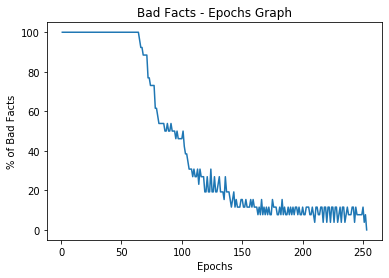

In [0]:
mlp.plot()

## Testing

In [0]:
mlp.test(testing_df)

[0. 0. 0. 1. 1.] ----------> [0.92851383 0.09595286 0.14115295]
True ! (Target:  [1. 0. 0.] )
[1. 0. 0. 0. 0.] ----------> [0.14452199 0.09745992 0.15529479]
True ! (Target:  [0. 0. 0.] )
[1. 1. 0. 1. 0.] ----------> [0.18865015 0.87859423 0.12530087]
True ! (Target:  [0. 1. 0.] )
[0. 0. 1. 0. 0.] ----------> [0.72443813 0.18081394 0.88784415]
False ! (Target:  [1. 0. 1.] )
[0. 0. 0. 0. 1.] ----------> [0.87441798 0.14913198 0.17489075]
True ! (Target:  [1. 0. 0.] )
[0. 1. 0. 1. 0.] ----------> [0.91935698 0.87818715 0.17011708]
True ! (Target:  [1. 1. 0.] )

Accuracy:  83.33333333333334 %


As can be seen from the above code snippet, the test produced a classification accuracy of 83.3%. The testing dataset (which contains six values) was used.

## Issues Encountered

The bulk of issues stemmed from the alignment of indices of the several Numpy arrays and matrices which were used throughout the project, which were greatly impacting the MLP's performance. There were also some issues involving improper indentation of code instructions that, in Python, function differently if misaligned. Another issue which took a substantial amount of time arose from the error-checking component, in which multiplication was returning skewed results. This was determined to have been caused by losses in precision due to the conversion of certain array elements. 